In [1]:
import torchinfo
import numpy as np
import torch
from murenn import DTCWTDirect, MuReNNDirect
from models.basic import get_model
from matplotlib import pyplot as plt

# Calculate parameters & macc

In [2]:
MAX_PARAMS = 32000
MAX_MACC = 30e6

def get_torch_size(model, input_size):
    model_profile = torchinfo.summary(model, input_size=input_size)
    return model_profile.total_mult_adds, model_profile.total_params

def validate(macc, params):
    print('Model statistics:')
    print('MACC:\t \t %.3f' %  (macc/1e6), 'M')
    print('Memory:\t \t %.3f' %  (params/1e3), 'K\n')
    if macc>MAX_MACC:
        print('[Warning] Multiply accumulate count', macc, 'is more than the allowed maximum of', int(MAX_MACC))
    if params>MAX_PARAMS:
        print('[Warning] parameter count', params, 'is more than the allowed maximum of', int(MAX_PARAMS))

In [3]:
mmcs, para = get_torch_size(DTCWTDirect(), input_size=(1,1,44100))
print(f'dtcwt:mmacs:{mmcs}; para:{para}')

dtcwt:mmacs:0; para:0


In [4]:
for alpha in [5, 10, 15, 18, 22, 33, 66]:
    beta = int(330//alpha)
    mmcs, para = get_torch_size(get_model(alpha=alpha,beta=beta,m=1,n=1), input_size=(1,1,44100))
    print(mmcs)
    print(para)

29744890
10900


/Users/zhang/anaconda3/envs/dcase/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1714549139058/work/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,


29744890
10900
29744890
10900
29204074
10702
29744890
10900
29744890
10900
29744890
10900


In [5]:
for m,n in zip([1, 2, 5], [3, 2, 1]):
    alpha = 5
    beta = 64
    mmcs, para = get_torch_size(get_model(alpha=alpha,beta=beta,m=m,n=n), input_size=(1,1,44100))
    print(mmcs)
    print(para)

30076170
25930
29690250
27850
29304330
29770


# histogram

In [6]:
from torch.utils.data import DataLoader
from dataset.dcase24 import get_training_set, get_test_set, get_eval_set

In [7]:
# a random sample (without preprocessing)
dataset = get_training_set(
    split=100,
    roll=0,
    dir_prob=0,
)
train_idx = torch.randint(len(dataset), size=(1,)).item()
x, files, labels, devices, cities = dataset[train_idx]
print(f"file name:\n{files}")

file name:
audio/public_square-stockholm-121-3564-2-s2.wav


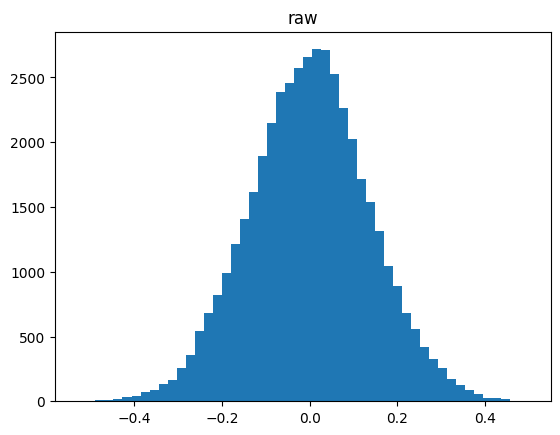

tensor(829.6797)


In [8]:
n_bins=50
plt.hist(x, bins=n_bins)
plt.title("raw")
plt.show()
enj_raw = torch.norm(x, p="fro")**2
print(enj_raw)

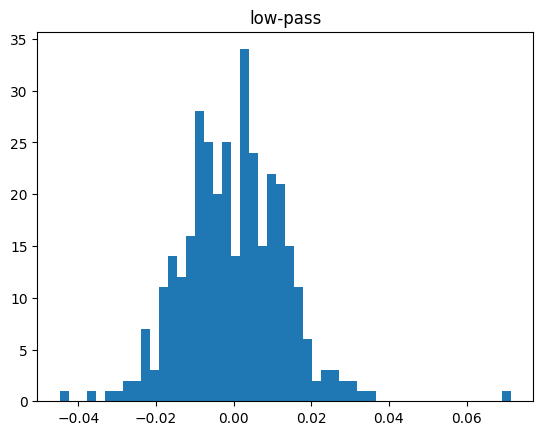

0.05860474073938726


In [9]:
dtcwt = DTCWTDirect(normalize=True)
x = torch.Tensor(x).view(1,1,-1)
lp, bps = dtcwt(x)
lp = lp.numpy().flatten()
plt.hist(lp, bins=n_bins)
plt.title("low-pass")
plt.show()
enj_lp = np.linalg.norm(lp)**2
print(enj_lp)

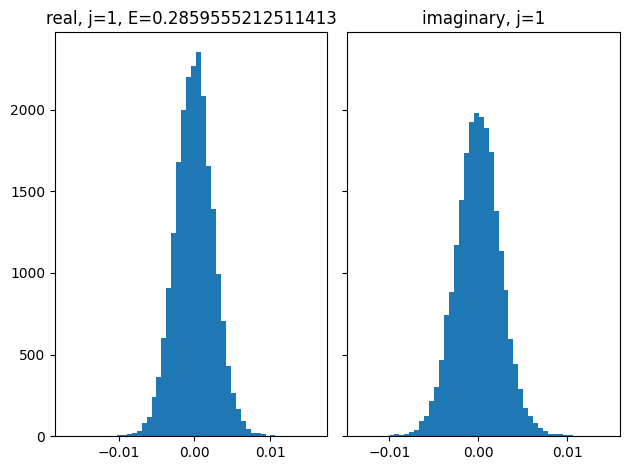

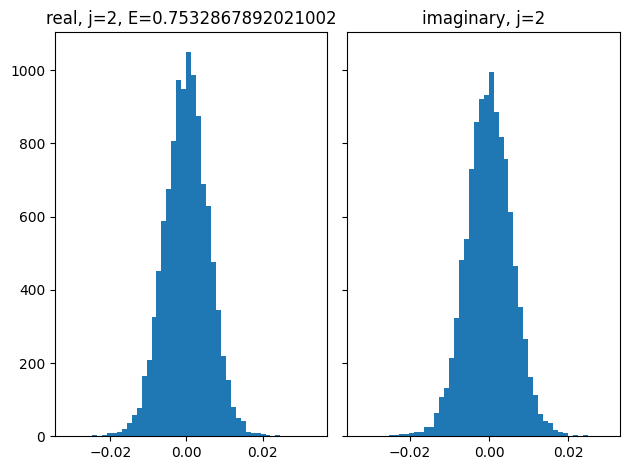

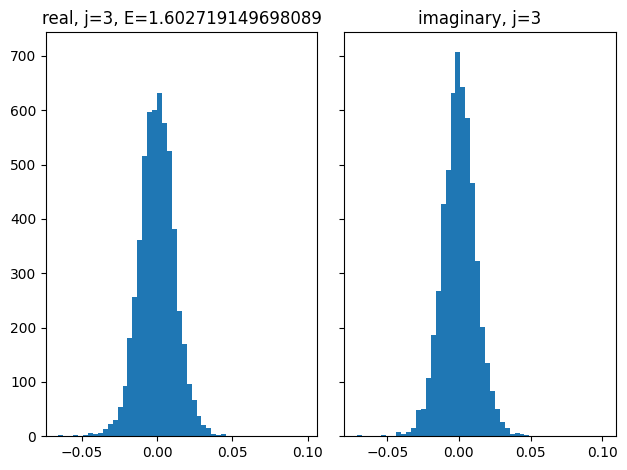

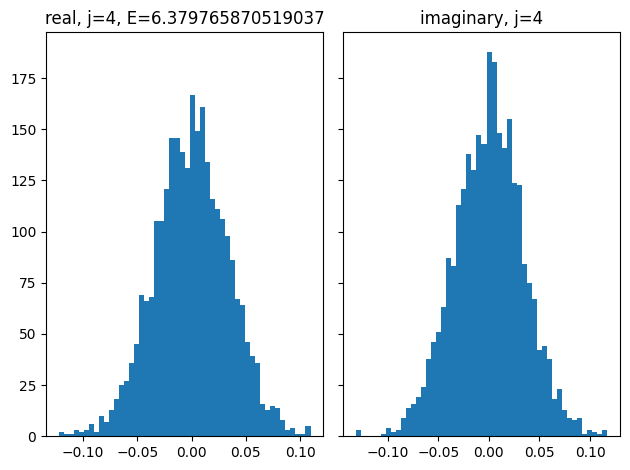

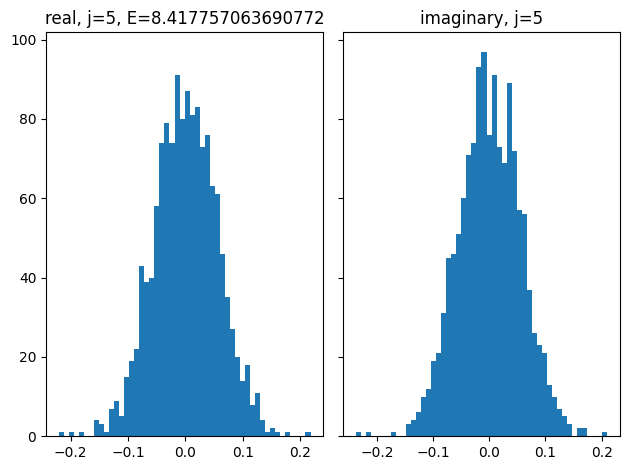

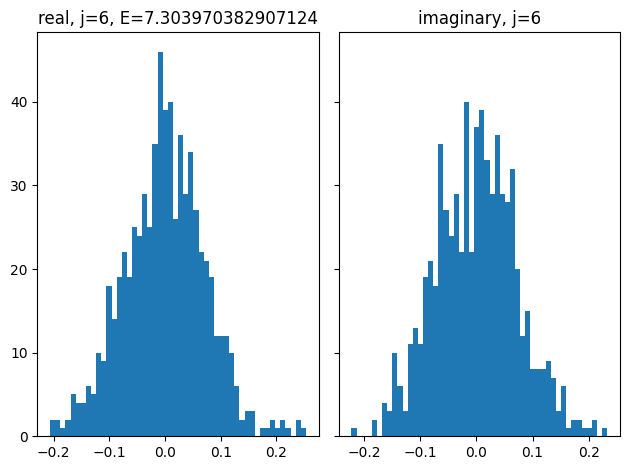

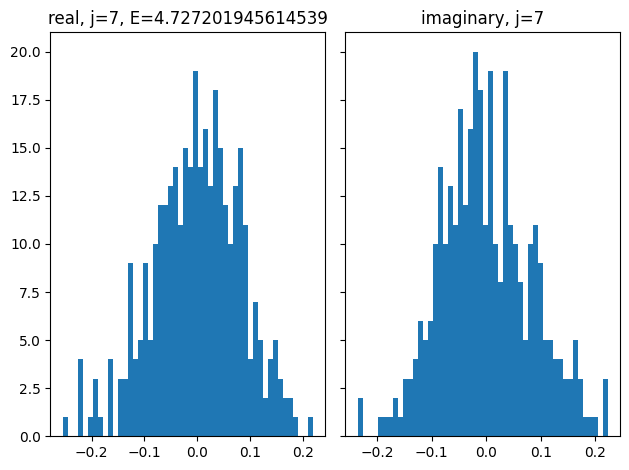

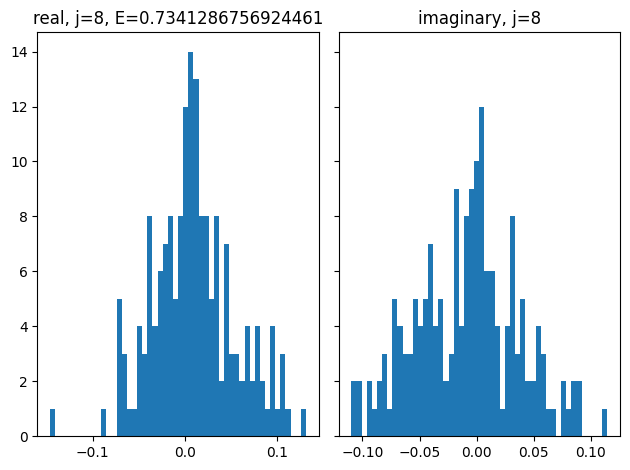

30.204785398575247


In [10]:
enj_bps = 0
for j in range(len(bps)):
    bp = bps[j].numpy().flatten()
    enj_j = np.linalg.norm(bp.real)**2 + np.linalg.norm(bp.imag)**2
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(bp.real, bins=n_bins)
    axs[1].hist(bp.imag, bins=n_bins)
    axs[0].title.set_text(f"real, j={j+1}, E={enj_j}")
    axs[1].title.set_text(f"imaginary, j={j+1}")
    plt.show()
    enj_bps = enj_bps + enj_j

print(enj_bps)


In [11]:
import murenn

In [12]:
print(lp.shape)

(346,)


In [13]:
for bp in bps:
    print(bp.shape)

torch.Size([1, 1, 22050])
torch.Size([1, 1, 11025])
torch.Size([1, 1, 5513])
torch.Size([1, 1, 2757])
torch.Size([1, 1, 1379])
torch.Size([1, 1, 690])
torch.Size([1, 1, 345])
torch.Size([1, 1, 173])


In [14]:
J = 4
Q = 1
T = 3
murenn_layer = MuReNNDirect(
    J=J, 
    Q=Q, 
    T=T, 
    in_channels=1,
)

y_jq = murenn_layer(x)

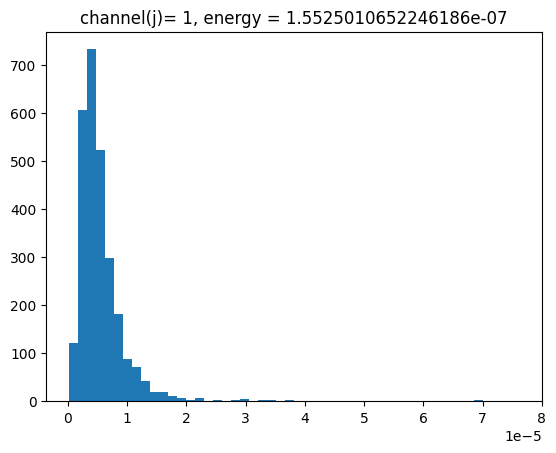

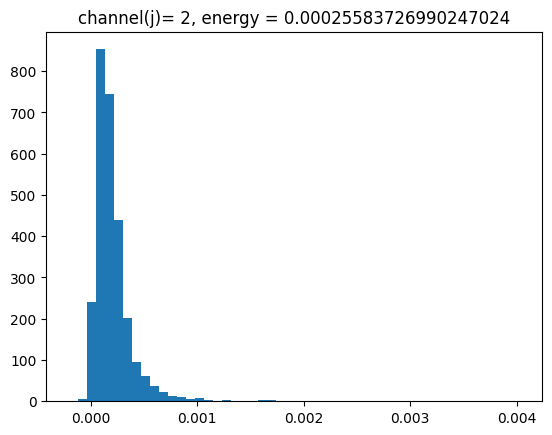

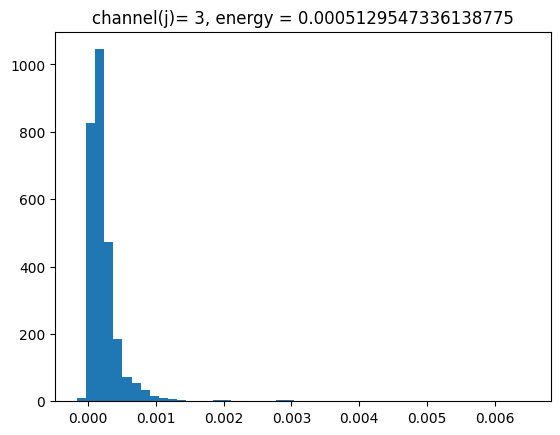

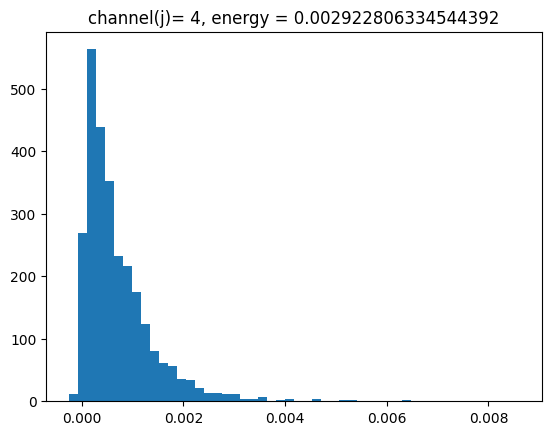

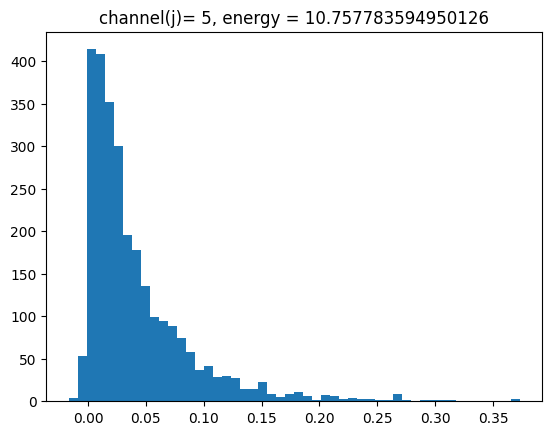

10.761475348538294


In [15]:
energy = 0
y_jq = y_jq.view(J+1,-1)
for j in range(J+1):
    y_j = y_jq[j, :]
    y_j = y_j.detach().numpy().flatten()
    energy_j = np.linalg.norm(y_j)**2
    plt.hist(y_j, bins=n_bins)
    plt.title(f"channel(j)= {j+1}, energy = {energy_j}")
    plt.show()
    energy = energy + energy_j
print(energy)